# EMG Decomposition - Mateo Umaguing

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.signal as sig

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

## Input File

### Run the corresponding cell to read in the respective file, do not change the file inputs

### Example 1

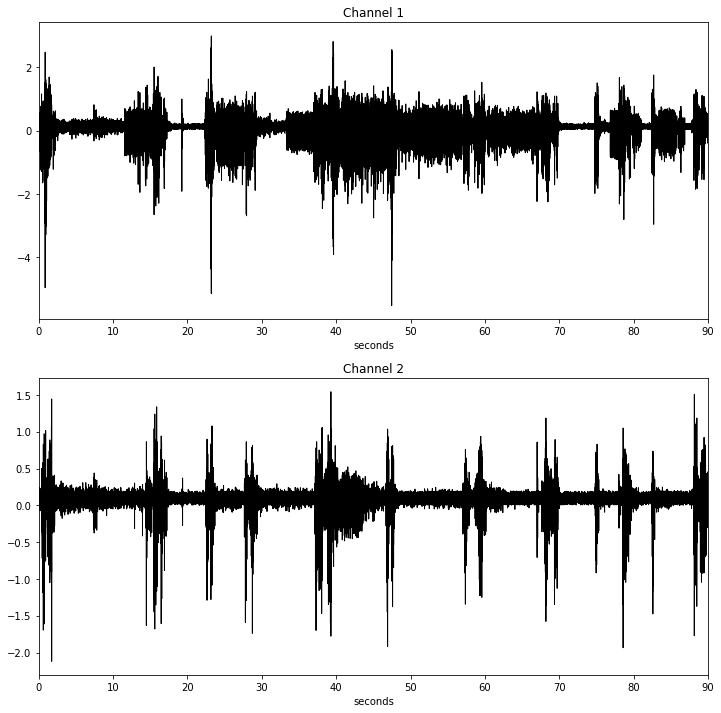

In [98]:
M = pd.read_csv('EMG_example_1_90s_fs_2k.csv', header=None)

time = np.linspace(0, (len(M) - 1) / 2000, len(M))
fs = 2000

channel_number = np.shape(M)[1] # num of channels in the database

fig, ax = plt.subplots(2, 1, figsize=(12,12)) # plot each channel
for i in range(channel_number):
    ax[i].plot(time, M.loc[:,i], linewidth=1, color='black')
    ax[i].set_xlabel("seconds") # label and title each plot
    ax[i].set_title(f"Channel {i+1}")
    ax[i].set_xlim(time[0], time[-1])
    
channel_select = 1 # select channel for testing. channel_select <= channel_number. this ranges from 0 to 1
test_input = M.loc[:,channel_select].to_numpy()

chosen_channel= f'EMG example 1, channel {channel_select+1}'

### Example 2

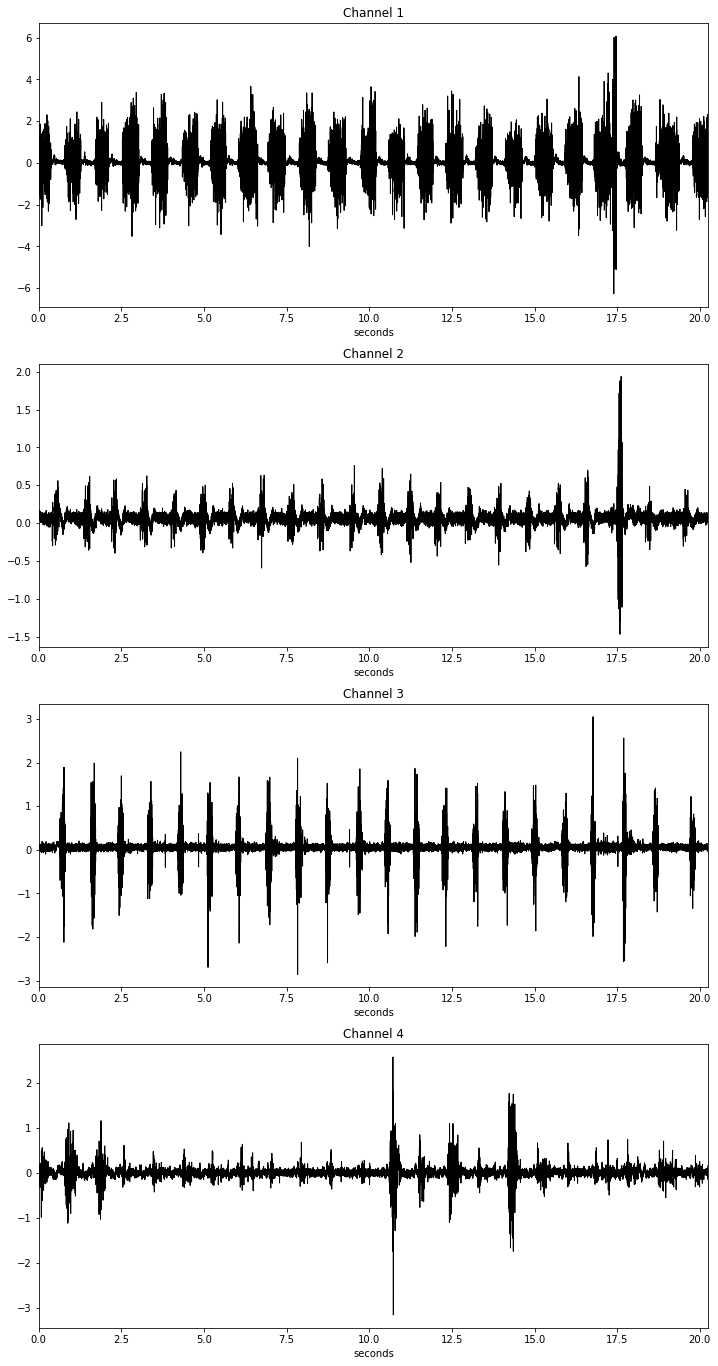

In [3]:
M = pd.read_csv('EMG_example_2_fs_2k.csv', header=None) # read in csv file

time = M.loc[:,0].to_numpy() # first column is time series
fs = (time[1] - time[0])**-1 # calculate the sample frequency 

channel_number = np.shape(M)[1] - 1 # num of channels in the database

fig, ax = plt.subplots(4, 1, figsize=(12,24)) # plot each channel
for i in range(channel_number):
    ax[i].plot(time, M.loc[:,i+1], linewidth=1, color='black')
    ax[i].set_xlabel("seconds") # label and title each plot
    ax[i].set_title(f"Channel {i+1}")
    ax[i].set_xlim(time[0], time[-1])
    
channel_select = 4 # select channel for testing. channel_select <= channel_number. this ranges from 1 to 4 
test_input = M.loc[:,channel_select].to_numpy()

chosen_channel= f'EMG example 2, channel {channel_select}'

### Example 20s

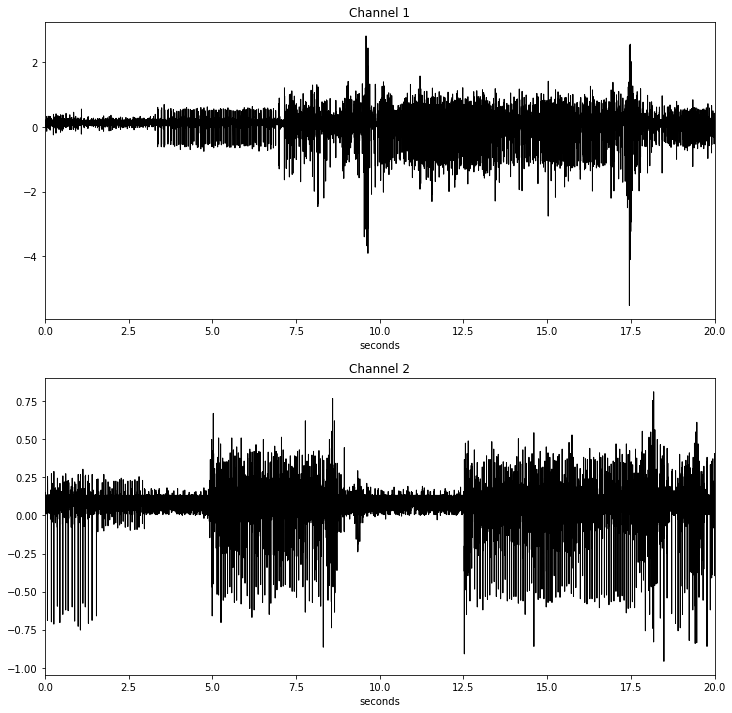

In [121]:
M = pd.read_csv('EMG_example_20s_2000Hz-2022.csv', header=None)

time = np.linspace(0, (len(M) - 1) / 2000, len(M))
fs = 2000

channel_number = np.shape(M)[1] # num of channels in the database

fig, ax = plt.subplots(2, 1, figsize=(12,12)) # plot each channel
for i in range(channel_number):
    ax[i].plot(time, M.loc[:,i], linewidth=1, color='black')
    ax[i].set_xlabel("seconds") # label and title each plot
    ax[i].set_title(f"Channel {i+1}")
    ax[i].set_xlim(time[0], time[-1])
    
channel_select = 0 # select channel for testing. channel_select <= channel_number. this ranges from 0 to 1
test_input = M.loc[:,channel_select].to_numpy()

chosen_channel= f'EMG example 20s, channel {channel_select+1}'

In [4]:
print(chosen_channel)

EMG example 2, channel 4


## Band-pass filtering

In [5]:
bp_20 = sig.butter(4, [20*2/fs, 500*2/fs], btype='bandpass', output='sos') # create 20-500 Hz bandpass filter

bp_signal = sig.sosfilt(bp_20, test_input) # apply filter to signal

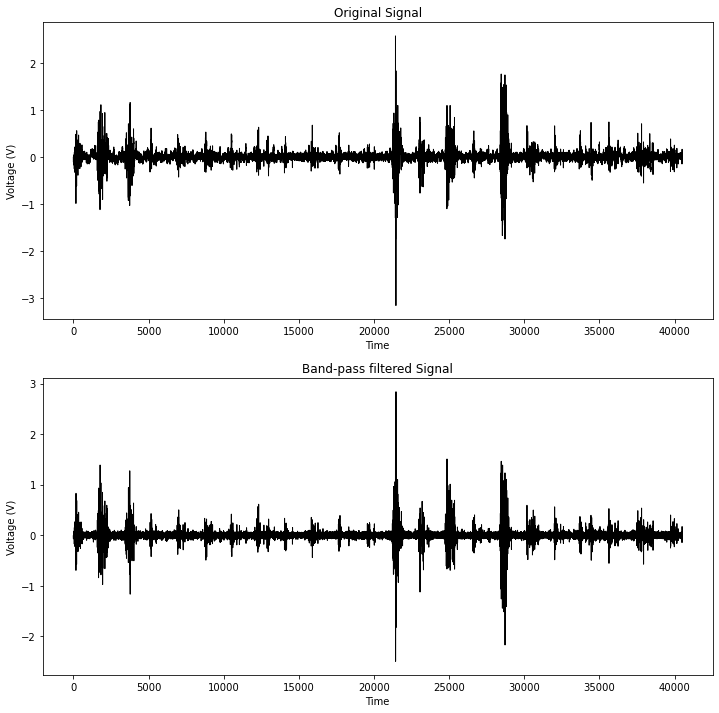

In [6]:
# plot original and bandpass-filtered signals
fig, ax = plt.subplots(2, 1, figsize=(12, 12))

ax[0].plot(test_input, linewidth=1, color='black')
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Voltage (V)")
ax[0].title.set_text("Original Signal")

ax[1].plot(bp_signal, linewidth=1, color='black')
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Voltage (V)")
ax[1].title.set_text("Band-pass filtered Signal")

## Spike Detection

Methodology adapted from Gibson et al. 2008, *Comparison of spike-sorting algorithms for future hardware implementation*

In [125]:
x = bp_signal

$$
Thr = 4\sigma_N,\ \ \sigma_N = \textrm{median}\{ \frac{|x(n)|}{0.6745} \}
$$

In [126]:
T = 4 * np.median(np.abs(x) / 0.6745)
T

0.3872700229381252

In [127]:
half_w_len = 8 # half of the length of the window for finding spikes

peak_indices = sig.find_peaks(np.abs(x), height=T, distance=half_w_len) # find peaks according to threshold
peaks = np.asarray([(pi, x[pi]) for pi in peak_indices[0]]) # peak points

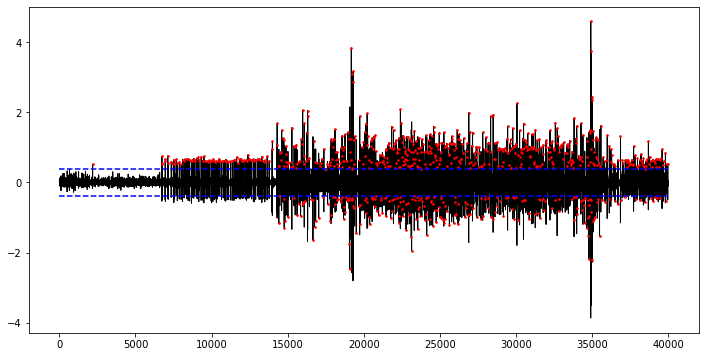

In [128]:
# plot detected peaks
fig = plt.figure(figsize=(12,6))
plt.plot(x, linewidth=1, color='black', zorder=1)
plt.scatter(peaks[:,0], peaks[:,1], c='red', marker='.', s=10, zorder=2)
plt.hlines([-T, T], xmin=0, xmax=len(x), linestyles='--', color='blue', zorder=3) # threshold

## Spike Alignment

In [129]:
muap_cans = []
half_w_len = 8

for i in peak_indices[0]:
    if i+half_w_len < len(x):
        # add window centered around each spike to list of MUAP candidates
        muap_cans.append(x[(i-half_w_len):(i+half_w_len)]) 
    
muap_cans = np.asarray(muap_cans)
n = len(muap_cans)

peaks = peaks[0:n]
peak_indices = peak_indices[0][0:n]

In [130]:
print(f'There were {len(muap_cans)} possible spikes detected.')

There were 835 possible spikes detected.


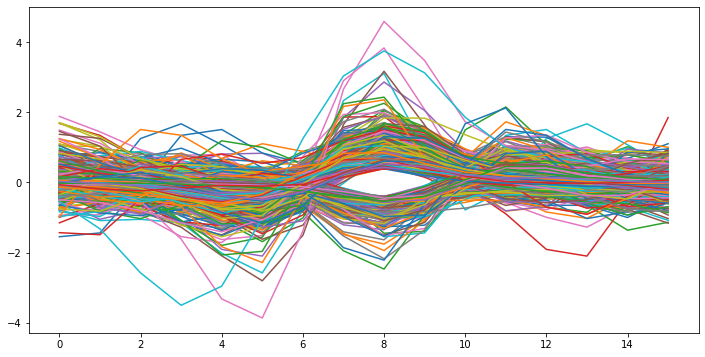

In [131]:
# plot all spikes
fig = plt.figure(figsize=(12,6))
for can in muap_cans:
    plt.plot(can)

## Feature Extraction

Every spike will be reduced in dimension using the following:
$$
c_i=\sum_{n=1}^N PC_{i}(n)\cdot s(n)
$$
where $c_i$ is one of 3 components of a dimension reduced spike, $PC_i$ is the $i$'th principal component, and $s(n)$ is the spike at time $n$. 

Methodology adapted from Gibson et al. 2008, *Comparison of spike-sorting algorithms for future hardware implementation*.

In [132]:
def scale_PCA(X, n_com):
    '''
    Scales input matrix and applies PCA
    '''
    scaler = StandardScaler()
    scaler.fit(X)
    mc_s = scaler.transform(X)

    pca = PCA(n_components=n_com)
    pca.fit(mc_s.T)

    return (pca.components_), np.sum(pca.explained_variance_ratio_)

In [133]:
# apply PCA to the MUAP candidates
muaps_PCA,_ = scale_PCA(muap_cans.T, 3)
muaps_PCA.shape # print shape of principal components matrix

(3, 16)

In [134]:
dr_spikes = []

# compute PC coefficients for each spike
for muap in muap_cans:
    c1, c2, c3 = muap @ muaps_PCA[0], muap @ muaps_PCA[1], muap @ muaps_PCA[2]
    dr_spikes.append([c1, c2, c3])
    
dr_spikes = np.array(dr_spikes)
dr_spikes.shape

(835, 3)

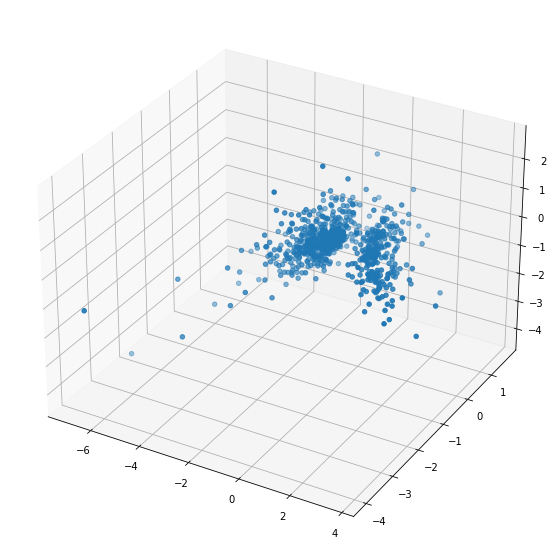

In [135]:
# plot dimension-reduced spikes
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.scatter(dr_spikes[:,0], dr_spikes[:,1], dr_spikes[:,2])

## K-Means Clustering

We will now find the optimal value of $k$ for $k$-means clustering by plotting the cost and choosing the $k$ where the first elbow in the curve appears.

In [136]:
# compute cost for different values of k
km_cost = np.zeros(20)
k = np.arange(2, 22)
for i in range(2,22):
    km = KMeans(n_clusters=i, random_state=0).fit(dr_spikes)
    km_cost[i-2] = km.inertia_ # cost

Text(0, 0.5, 'Inertia')

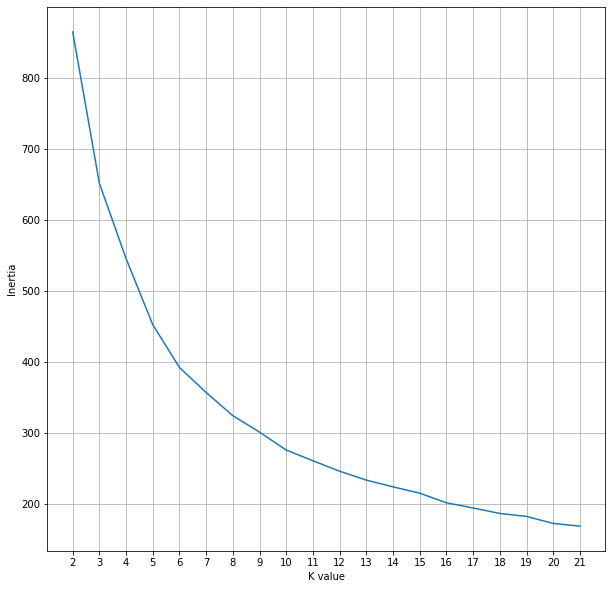

In [137]:
# plot cost for different values of k
fig = plt.figure(figsize=(10,10))
plt.grid()
tickpos = np.arange(2, 22)
plt.xticks(tickpos)
plt.plot(k, km_cost)
plt.xlabel("K value")
plt.ylabel("Inertia")

### Value of k depends on where the first "elbow" is - where the first visible bend in the plot is (usually around 3 or 4)

In [138]:
kval = int(input("Enter k-value: ")) # user-defined based on graph
print(f'Chosen value of k/number of MUs: {kval}')

Enter k-value: 3
Chosen value of k/number of MUs: 3


In [139]:
# apply k-means clustering using chosen k value
km = KMeans(n_clusters=kval, random_state=0).fit(dr_spikes)
mc_km = km.labels_

In [140]:
# colors for plotting
colors = {0:'#fde725', 1:'#440154', 2:'#21918c',
          3:'#bddf26', 4:'#482475', 5:'#2a788e',
          6:'#414487', 7:'#7ad151', 8:'#355f8d'}
cluster_colors = [colors[i] for i in mc_km]

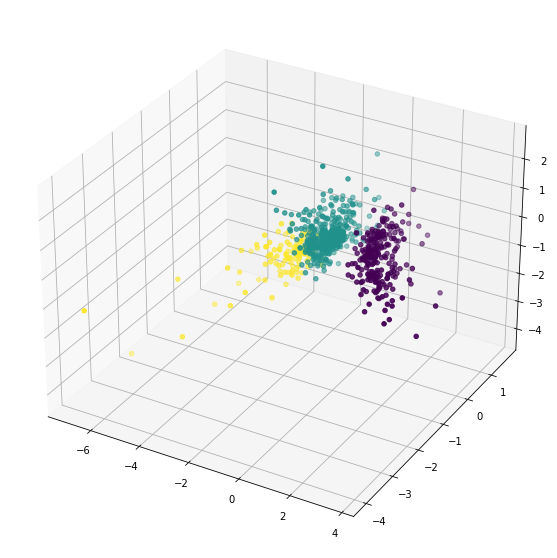

In [141]:
# plot 
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.scatter(dr_spikes[:,0], dr_spikes[:,1], dr_spikes[:,2], c=cluster_colors)

## Spike Classification

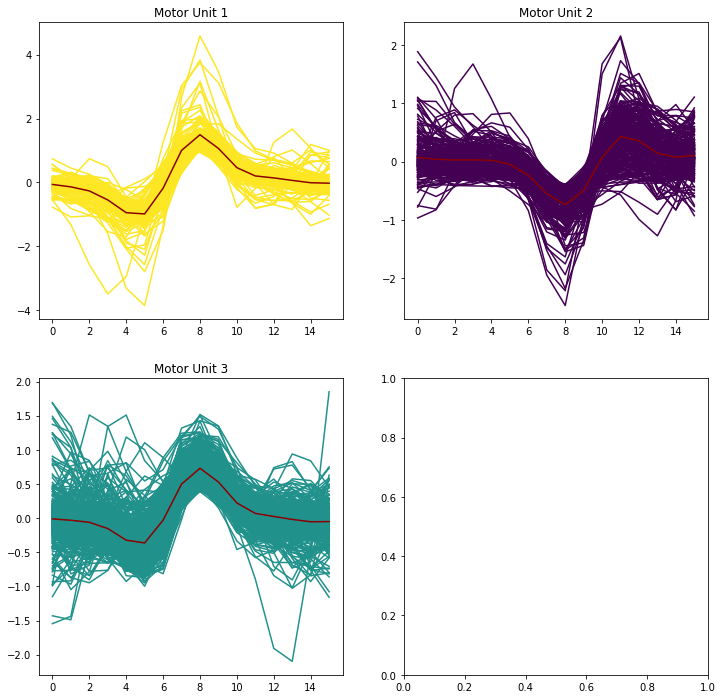

In [142]:
average_MUAPs = []
count_MUAPs = []

# plot all spikes by cluster and average
fig, ax = plt.subplots(2, 2, figsize=(12,12))
ax = ax.flatten()
for i in range(kval):
    clustered_MUAPs = muap_cans[mc_km == i] # which MUAPs correspond to which cluster
    
    # get spike average and counts
    avg_MUAP = np.mean(clustered_MUAPs, axis=0)
    average_MUAPs.append(avg_MUAP)
    count_MUAPs.append(len(clustered_MUAPs))
    
    # plotting
    for muap in clustered_MUAPs:
        ax[i].plot(muap, color=colors[i], zorder=1)
    ax[i].plot(avg_MUAP, color='darkred', zorder=2)
    ax[i].set_title(f'Motor Unit {i+1}')

## Analysis

In [143]:
def extract_attributes(muap):
    '''
    Extracts attributes from a single MUAP
    
    inputs:
    muap - MUAP signal
    '''
    N = len(muap)
    
    fd = np.gradient(muap)
    sd = np.gradient(fd)
    
    # spike height
    sh = np.max(np.abs(muap))
    
    # spike min, spike max
    smn, smx = np.min(muap), np.max(muap)
    
    # max, min of first derivative
    fd_mx, fd_mn = np.max(fd), np.min(fd)
    
    # max, min of second derivative
    sd_mx, sd_mn = np.max(sd), np.min(sd)
    
    return [sh, smn, smx, fd_mx, fd_mn, sd_mx, sd_mn]

In [144]:
for i in range(len(count_MUAPs)):
    firing_rate = (count_MUAPs[i] / len(x)) * fs
    print(f'Motor Unit {i+1} has a firing rate of {firing_rate} Hz over {len(x)/fs} seconds.')

Motor Unit 1 has a firing rate of 6.149846253843654 Hz over 20.0005 seconds.
Motor Unit 2 has a firing rate of 11.899702507437315 Hz over 20.0005 seconds.
Motor Unit 3 has a firing rate of 23.69940751481213 Hz over 20.0005 seconds.


In [145]:
avg_attributes = [extract_attributes(muap) for muap in average_MUAPs]

In [146]:
# average MUAP characteristics
for i in range(kval):
    print(f'Motor Unit {i+1} Spike Height: {avg_attributes[i][0]}')
    print(f'Motor Unit {i+1} Spike Minimum: {avg_attributes[i][1]}')
    print(f'Motor Unit {i+1} Spike Maximum: {avg_attributes[i][2]}')
    print(f'Motor Unit {i+1} First Derivative Maximum: {avg_attributes[i][3]}')
    print(f'Motor Unit {i+1} First Derivative Minimum: {avg_attributes[i][4]}')
    print(f'Motor Unit {i+1} Second Derivative Maximum: {avg_attributes[i][5]}')
    print(f'Motor Unit {i+1} Second Derivative Minimum: {avg_attributes[i][6]}')
    print("\n")

Motor Unit 1 Spike Height: 1.491650215859207
Motor Unit 1 Spike Minimum: -0.9900632909254168
Motor Unit 1 Spike Maximum: 1.491650215859207
Motor Unit 1 First Derivative Maximum: 0.9946187900641862
Motor Unit 1 First Derivative Minimum: -0.5156302494519636
Motor Unit 1 Second Derivative Maximum: 0.6071328902496833
Motor Unit 1 Second Derivative Minimum: -0.6770147391798069


Motor Unit 2 Spike Height: 0.7404409823953138
Motor Unit 2 Spike Minimum: -0.7404409823953138
Motor Unit 2 Spike Maximum: 0.4293790036701257
Motor Unit 2 First Derivative Maximum: 0.4596780890602011
Motor Unit 2 First Derivative Minimum: -0.25197908749461595
Motor Unit 2 Second Derivative Maximum: 0.3298505478326565
Motor Unit 2 Second Derivative Minimum: -0.30161847061312386


Motor Unit 3 Spike Height: 0.7302441109373945
Motor Unit 3 Spike Minimum: -0.36350194488237214
Motor Unit 3 Spike Maximum: 0.7302441109373945
Motor Unit 3 First Derivative Maximum: 0.43078759373791203
Motor Unit 3 First Derivative Minimum: -0

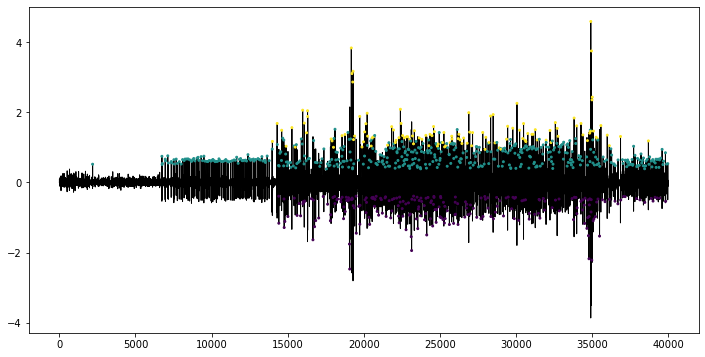

In [147]:
# plot classified peaks
fig = plt.figure(figsize=(12,6))
plt.plot(x, linewidth=1, color='black', zorder=1)
plt.scatter(peaks[:,0], peaks[:,1], marker='.', s=15, c=cluster_colors, zorder=2)

### Spike Trains

In [148]:
spike_trains = np.zeros((kval, len(x)))

for i in range(kval):
    spike_trains[i,peak_indices[mc_km == i]] = 1 # create a train of spikes for each MU
    
spike_times = []
for i in range(kval):
    spike_times.append(np.where(spike_trains[i] == 1)) # create a vector of where each MU is spiking

In [149]:
spike_hists = []

for i in range(kval):
    spike_hists.append(np.zeros(len(x)))
    for j in range(400, len(x), 400):
        spike_hists[i][(j-400):(j)] = np.sum(spike_trains[i,(j-400):j]) # spike counts in 200ms intervals

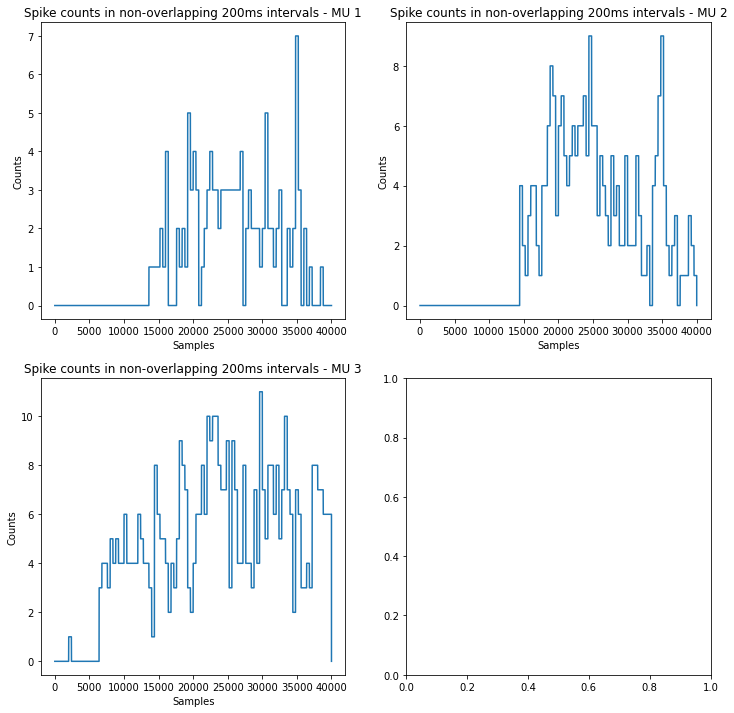

In [150]:
fig, ax = plt.subplots(2, 2, figsize=(12,12))
ax = ax.flatten()
for i in range(kval):
    ax[i].plot(spike_hists[i])
    ax[i].set_title(f"Spike counts in non-overlapping 200ms intervals - MU {i+1}")
    ax[i].set_xlabel("Samples")
    ax[i].set_ylabel("Counts")

### Interspike Intervals

In [151]:
ISIs = []
for i in range(kval):
    ISIs.append(np.diff(spike_times[i])) # calculate interspike intervals
len(ISIs)

3

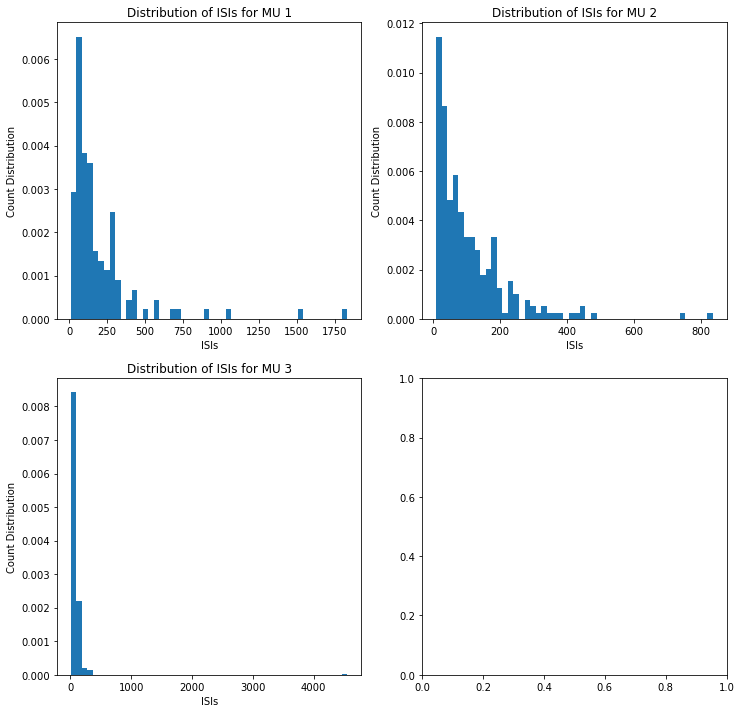

In [152]:
fig, ax = plt.subplots(2, 2, figsize=(12,12))
ax = ax.flatten()
for i in range(kval):
    ax[i].hist(ISIs[i][0], bins=50, density=True)
    ax[i].set_title(f'Distribution of ISIs for MU {i+1}')
    ax[i].set_xlabel("ISIs")
    ax[i].set_ylabel("Count Distribution")

In [153]:
for i in range(kval):
    print(f'Motor unit {i} mean ISI: {np.mean(ISIs[i]) / 2000} s')

Motor unit 0 mean ISI: 0.10126229508196721 s
Motor unit 1 mean ISI: 0.05364345991561181 s
Motor unit 2 mean ISI: 0.039953488372093025 s
